# **Clustering Dengan K-Means**

# Formulasi Masalah

Masalah yang akan di selesaikan adalah mengclustering dataset kendaraan menjadi 
n_cluster dan memprediksi apakah pelanggan tertarik untuk membeli kendaraan baru atau 
tidak berdasarkan data pelanggan di dealer.


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import datetime

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Eksplorasi Data

In [2]:
df_test = pd.read_csv('/content/drive/MyDrive/kendaraan_test.csv')

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/kendaraan_train.csv')
df_train

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
285826,285827,Wanita,23.0,1.0,4.0,1.0,< 1 Tahun,Tidak,25988.0,152.0,217.0,0
285827,285828,Wanita,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,44686.0,152.0,50.0,0
285828,285829,Wanita,23.0,1.0,50.0,1.0,< 1 Tahun,Tidak,49751.0,152.0,226.0,0
285829,285830,Pria,68.0,1.0,7.0,1.0,1-2 Tahun,Tidak,30503.0,124.0,270.0,0


In [4]:
df_train.dtypes

id                     int64
Jenis_Kelamin         object
Umur                 float64
SIM                  float64
Kode_Daerah          float64
Sudah_Asuransi       float64
Umur_Kendaraan        object
Kendaraan_Rusak       object
Premi                float64
Kanal_Penjualan      float64
Lama_Berlangganan    float64
Tertarik               int64
dtype: object

In [5]:
#Mereplace Umur_Kendaraan
df_train.replace(['1-2 Tahun', '< 1 Tahun','> 2 Tahun'], [2,1,3], inplace=True) 
#Mereplace Kendaraan Rusak
df_train.replace(['Pernah', 'Tidak'], [1,0], inplace=True)
#Mreplace Jenis Kelamin
df_train.replace(['Wanita', 'Pria'], [0,1], inplace=True)

In [6]:
#ngedrop data kosong/Nan
df_train.dropna(inplace=True)
df_train

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,0.0,30.0,1.0,33.0,1.0,1.0,0.0,28029.0,152.0,97.0,0
1,2,1.0,48.0,1.0,39.0,0.0,3.0,1.0,25800.0,29.0,158.0,0
3,4,0.0,58.0,1.0,48.0,0.0,2.0,0.0,2630.0,124.0,63.0,0
5,6,1.0,21.0,1.0,35.0,1.0,1.0,0.0,22735.0,152.0,171.0,0
8,9,0.0,20.0,1.0,8.0,1.0,1.0,0.0,30786.0,160.0,31.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
285826,285827,0.0,23.0,1.0,4.0,1.0,1.0,0.0,25988.0,152.0,217.0,0
285827,285828,0.0,21.0,1.0,46.0,1.0,1.0,0.0,44686.0,152.0,50.0,0
285828,285829,0.0,23.0,1.0,50.0,1.0,1.0,0.0,49751.0,152.0,226.0,0
285829,285830,1.0,68.0,1.0,7.0,1.0,2.0,0.0,30503.0,124.0,270.0,0


In [7]:
#ngedrop data id dan Tertarik
df_train.drop('id' , axis=1 , inplace=True)
df_train.drop('Tertarik' , axis=1 , inplace=True)
df_train

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan
0,0.0,30.0,1.0,33.0,1.0,1.0,0.0,28029.0,152.0,97.0
1,1.0,48.0,1.0,39.0,0.0,3.0,1.0,25800.0,29.0,158.0
3,0.0,58.0,1.0,48.0,0.0,2.0,0.0,2630.0,124.0,63.0
5,1.0,21.0,1.0,35.0,1.0,1.0,0.0,22735.0,152.0,171.0
8,0.0,20.0,1.0,8.0,1.0,1.0,0.0,30786.0,160.0,31.0
...,...,...,...,...,...,...,...,...,...,...
285826,0.0,23.0,1.0,4.0,1.0,1.0,0.0,25988.0,152.0,217.0
285827,0.0,21.0,1.0,46.0,1.0,1.0,0.0,44686.0,152.0,50.0
285828,0.0,23.0,1.0,50.0,1.0,1.0,0.0,49751.0,152.0,226.0
285829,1.0,68.0,1.0,7.0,1.0,2.0,0.0,30503.0,124.0,270.0


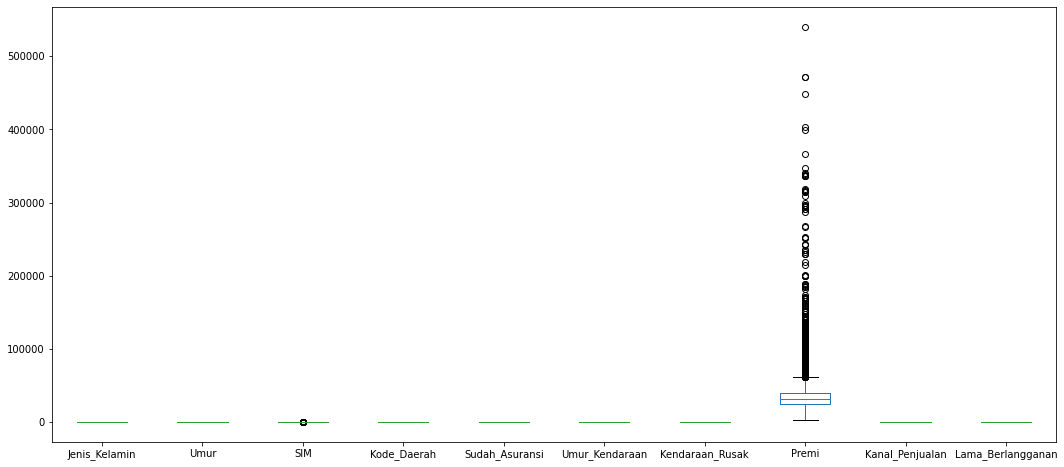

In [8]:
#Menampilkan distribusi pada dataframe df_train menggunakan boxplot
df_train.plot(kind='box', figsize =(18,8))

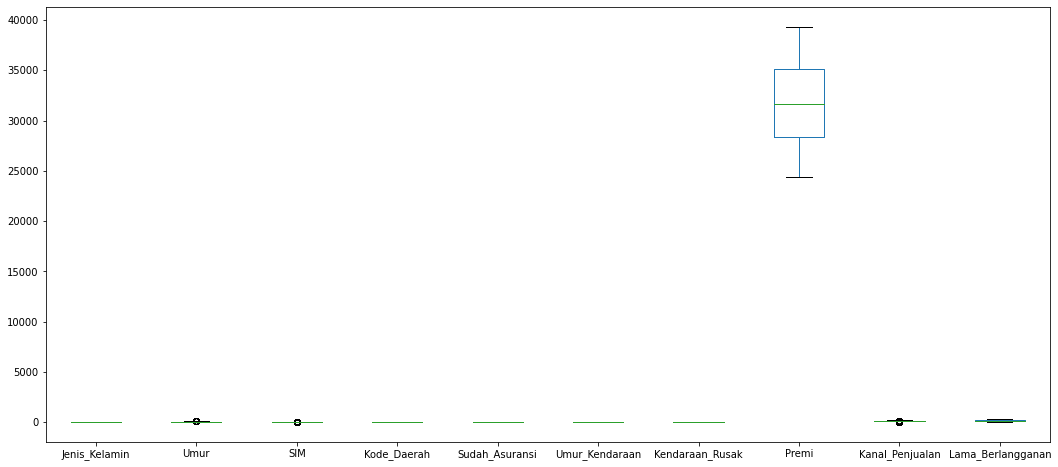

In [9]:
#Menghilangkan outlier pada premi dengan teknik persentil
upper_limit = df_train['Premi'].quantile(0.75)
lower_limit = df_train['Premi'].quantile(0.25)

df_train = df_train[(df_train['Premi'] < upper_limit) & (df_train['Premi'] > lower_limit)]
df_train

#menampilkan boxplot kolom year setelah dihilangkan outliernya
df_train.plot(kind='box', figsize =(18,8))

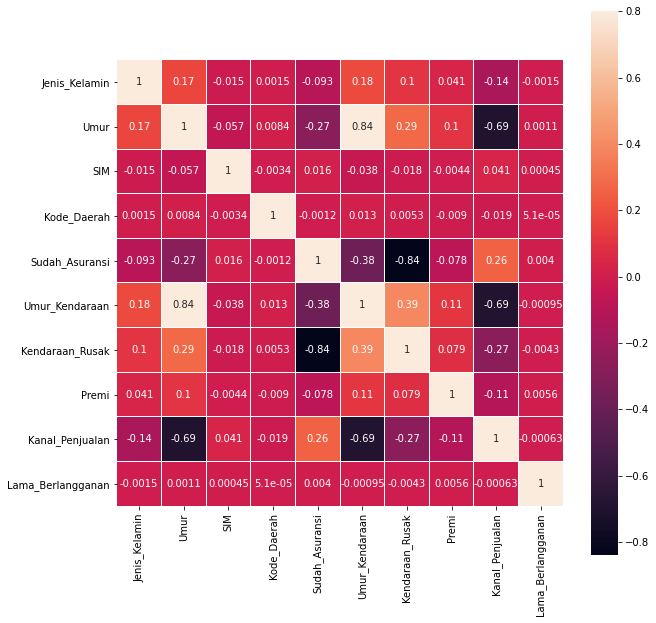

In [10]:
#Korelasi data train
df_train_corr = df_train.corr(method = 'spearman')
plt.figure(figsize=(10,10))
sns.color_palette("rocket", as_cmap=True)
sns.heatmap(df_train_corr, vmax=0.8, linewidths=0.01 ,square=True, annot=True)
plt.show()

In [11]:
#melakukan pencarian nilai korelasi untuk mendapatkan data yang optimal untuk di clustering
col_corr = set()
corr_min = 0.1
for i in range(len(df_train_corr.columns)):
    for j in range(i):
        if abs(df_train_corr.iloc[i, j]) > corr_min:
            colname = df_train_corr.columns[i]
            col_corr.add(colname)
df_train_features = df_train.drop(col_corr, axis=1)

In [12]:
df_train_features

,Jenis_Kelamin,SIM,Kode_Daerah,Lama_Berlangganan
0,0.0,1.0,33.0,97.0
1,1.0,1.0,39.0,158.0
8,0.0,1.0,8.0,31.0
10,1.0,1.0,14.0,282.0
14,1.0,1.0,24.0,281.0
...,...,...,...,...
285818,1.0,1.0,28.0,183.0
285821,1.0,1.0,14.0,172.0
285826,0.0,1.0,4.0,217.0
285829,1.0,1.0,7.0,270.0


In [13]:
#ngedrop data 0 1 di dalam df_train_features sebanyak 15 persen
df_train_features.drop(columns=df_train_features.columns[((df_train_features == 1).mean() > 0.15)], axis=1, inplace=True)

In [14]:
df_train_features

,Kode_Daerah,Lama_Berlangganan
0,33.0,97.0
1,39.0,158.0
8,8.0,31.0
10,14.0,282.0
14,24.0,281.0
...,...,...
285818,28.0,183.0
285821,14.0,172.0
285826,4.0,217.0
285829,7.0,270.0


# Data Pra-Proses

## Missing Value

In [15]:
#mengecek missing value
df_train_features.isna().sum()

Kode_Daerah          0
Lama_Berlangganan    0
dtype: int64

In [16]:
#Mengecek nilai skewness (normalnya dari -2 sampai 2)
df_train_features.skew(axis=0, skipna=True)

Kode_Daerah         -0.128592
Lama_Berlangganan   -0.000264
dtype: float64

## Outlier

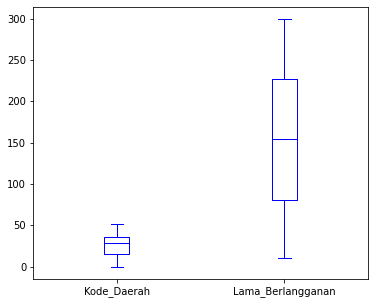

In [17]:
#mengecek outlier pada kolom kode daerah dan lama berlangganan  dalam dataset

outlier = df_train_features[['Kode_Daerah', 'Lama_Berlangganan']]

outlier.plot(kind='box', color='blue', vert=True, figsize=(6, 5))

## Scaling Data

### MinMax Scaling

In [18]:
#Scaling data menggunakan MinMax
from sklearn import preprocessing #mengimport library untuk praproses data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler() #mendafinisikan sc

#proses fueture scaling untuk data

hasilsc = sc.fit_transform(df_train_features)
df_train_minmax = pd.DataFrame(hasilsc, columns=df_train_features.columns)
display(df_train_minmax)

,Kode_Daerah,Lama_Berlangganan
0,0.634615,0.301038
1,0.750000,0.512111
2,0.153846,0.072664
3,0.269231,0.941176
4,0.461538,0.937716
...,...,...
85529,0.538462,0.598616
85530,0.269231,0.560554
85531,0.076923,0.716263
85532,0.134615,0.899654


### Standard Scaling

In [19]:
#Scaling data menggunakan StandarScaler
from sklearn import preprocessing #mengimport library untuk praproses data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler() #pendefinisian feature scaling

#proses feature scaling untuk data 
hasilsc = sc.fit_transform(df_train_features)
df_train_stand = pd.DataFrame(hasilsc, columns=df_train_features.columns)
display(df_train_stand)

,Kode_Daerah,Lama_Berlangganan
0,0.457298,-0.682758
1,0.906324,0.044231
2,-1.413642,-1.469335
3,-0.964616,1.522043
4,-0.216240,1.510126
...,...,...
85529,0.083110,0.342177
85530,-0.964616,0.211081
85531,-1.712993,0.747384
85532,-1.488480,1.379029


### Normalized Scaling

In [20]:
#Scaling data menggunakan Normalized
from sklearn import preprocessing #mengimport library untuk praproses data
from sklearn.preprocessing import Normalizer
sc = Normalizer() #pendefinisian feature scaling

#proses feature scaling untuk data 
hasilsc = sc.fit_transform(df_train_features)
df_train_norm = pd.DataFrame(hasilsc, columns=df_train_features.columns)
display(df_train_norm)

,Kode_Daerah,Lama_Berlangganan
0,0.322078,0.946713
1,0.239643,0.970861
2,0.249878,0.968277
3,0.049584,0.998770
4,0.085099,0.996372
...,...,...
85529,0.151245,0.988496
85530,0.081127,0.996704
85531,0.018430,0.999830
85532,0.025917,0.999664


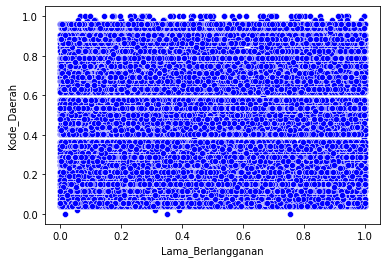

In [21]:
#Mengecek sebaran data kode daerah dan lama berlangganan
sns.scatterplot(x='Lama_Berlangganan', y='Kode_Daerah', data=df_train_minmax, color='blue')
# sns.scatterplot(x='Lama_Berlangganan', y='Kode_Daerah', data=df_train_stand, color='blue')
# sns.scatterplot(x='Lama_Berlangganan', y='Kode_Daerah', data=df_train_norm, color='blue')

#Export DataFrame

In [22]:
#export data frame ke file csv 
np.savetxt("Minmax.csv", df_train_minmax, delimiter=",")
np.savetxt("Standard.csv", df_train_stand, delimiter=",")
np.savetxt("Normalized.csv", df_train_norm, delimiter=",")
df_test.to_csv('test.csv', index=False)

# Pemodelan Menggunakan K-Means

In [23]:
import numpy as np
from numpy.linalg import norm

#membuat kelas untuk algoritma k-means
class Kmeans:
    #fungsi untuk membatasi n_cluster , maximal iterasi dan untuk merandom state
    def __init__(self, n_clusters, max_iter=100, random_state=123):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    #fungsi untuk menginilialisasi centroid
    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    #fungsi untuk menghitung centroid
    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    #fungsi untuk menghitung distance
    def compute_distance(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = norm(X - centroids[k, :], axis=1)
            distance[:, k] = np.square(row_norm)
        return distance

    #fungsi untuk menemukan cluster dari data
    def find_closest_cluster(self, distance):
        return np.argmin(distance, axis=1)

    #fungsi untuk menghitung nilai dari sse
    def compute_sse(self, X, labels, centroids):
        distance = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            distance[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(distance))

    # untuk menggenerate clustering
    def fit(self, X):
        self.centroids = self.initializ_centroids(X)
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        self.cluster_centers = X[initial]
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.compute_distance(X, old_centroids)
            self.labels = self.find_closest_cluster(distance)
            self.centroids = self.compute_centroids(X, self.labels)
            indices = [[i for i, l in enumerate(self.labels) if l == j]
                        for j in range(self.n_clusters)]
            X_by_cluster = [X[i] for i in indices]
            self.cluster_centers = [c.sum(axis=0) / len(c) for c in X_by_cluster]
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
        self.inertia = sum(((self.cluster_centers[l] - x)**2).sum()
                            for x, l in zip(X, self.labels))
        return self
    
    #untuk mengecek akurasi dan mengembalikan nilai cluster dari data
    def predict(self, X):
        distance = self.compute_distance(X, old_centroids)
        return self.find_closest_cluster(distance)

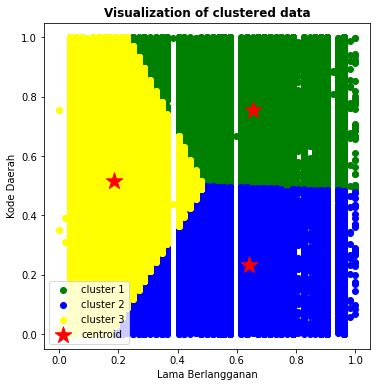

In [24]:
#untuk tahapan eksplorasi tinggal mengubah X_std
X_std = df_train_minmax.values
# X_std = df_train_norm.values
# X_std = df_train_stand.values

# Untuk menjalankan implementasi dari k-means
km = Kmeans(n_clusters=3, max_iter=100)
km.fit(X_std)
centroids = km.centroids

# Untuk plot cluster data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(X_std[km.labels == 2, 0], X_std[km.labels == 2, 1],
            c='yellow', label='cluster 3')
plt.scatter(centroids[:, 0], centroids[:, 1],  marker='*', 
            c='red', s=300, label='centroid')
plt.legend()

plt.xlabel('Lama Berlangganan')
plt.ylabel('Kode Daerah')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

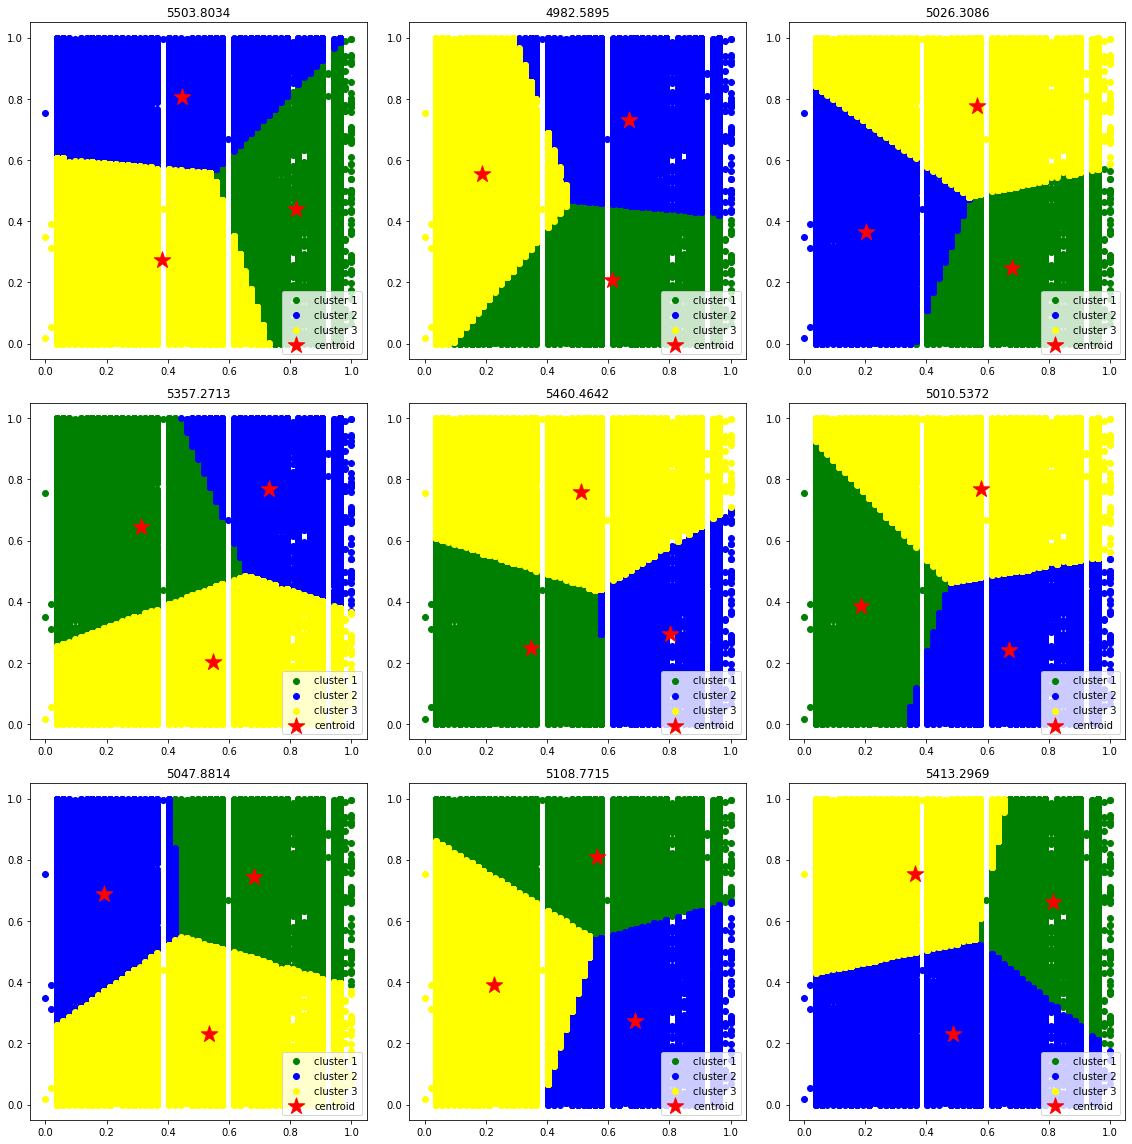

In [25]:
n_iter = 9
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = np.ravel(ax)
centers = []
for i in range(n_iter):
    # Untuk menjalankan implementasi k-means
    km = Kmeans(n_clusters=3,
                max_iter=3,
                random_state=np.random.randint(0, 1000, size=1))
    km.fit(X_std)
    centroids = km.centroids
    centers.append(centroids)
    ax[i].scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
                  c='green', label='cluster 1')
    ax[i].scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
                  c='blue', label='cluster 2')
    ax[i].scatter(X_std[km.labels == 2, 0], X_std[km.labels == 2, 1],
                  c='yellow', label='cluster 3')
    # ax[i].scatter(X_std[km.labels == 3, 0], X_std[km.labels == 3, 1],
    #               c='brown', label='cluster 4')
    # ax[i].scatter(X_std[km.labels == 4, 0], X_std[km.labels == 4, 1],
    #               c='pink', label='cluster 5')
    ax[i].scatter(centroids[:, 0], centroids[:, 1],
                  c='r', marker='*', s=300, label='centroid')
    ax[i].legend(loc='lower right')
    ax[i].set_title(f'{km.error:.4f}')
    ax[i].set_aspect('equal')
plt.tight_layout();

# Evaluasi

## Grafik Elbow

Text(0.5, 1.0, 'nilai k yang optimal menggunakan metode elbow')

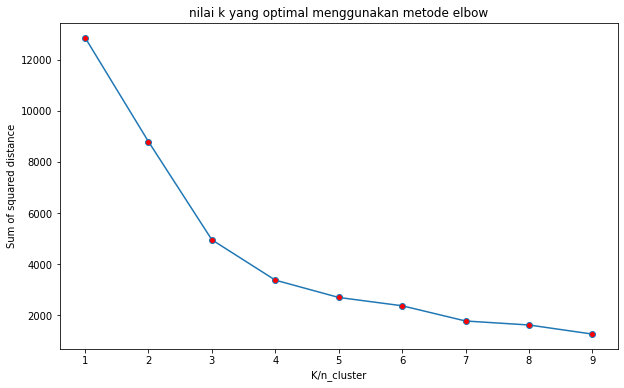

In [28]:
# Menjalankan algoritma kelas k-means untuk mendapatkan titik cluster index dengan menggunakan metode elbow
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = Kmeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia)

# Plot Grafik SSE dengan K/n_cluster
plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, marker='o', markerfacecolor ='red')
plt.xlabel('K/n_cluster')
plt.ylabel('Sum of squared distance');
plt.title('nilai k yang optimal menggunakan metode elbow')

## Nilai SSE

In [27]:
#melakukan evaluasi clustering dengan mencari nilai SSE(Sum of Square Error)
print('Dengan menggunakan n_cluster = 3') 
print('Nilai SSE = ',sse[3])

Dengan menggunakan n_cluster = 3
Nilai SSE =  3380.6015973864205
